get dataset

In [ ]:
# !wget https://github.com/alexeygrigorev/large-datasets/releases/download/dogs-cats/train.zip

In [ ]:
import shutil
import glob

import os
import re

import numpy as np

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 8, 6
# %matplotlib inline

In [ ]:
shutil.unpack_archive('train.zip', '')

* Create a `train` and `validation` folders
* In each folder, create `cats` and `dogs` folders

In [ ]:
!mkdir train/cats
!mkdir train/dogs

!mkdir validation
!mkdir validation/cats
!mkdir validation/dogs

In [ ]:
val_cats_folder = 'validation/cats'
train_cats_folder = 'train/cats'

val_dogs_folder = 'validation/dogs'
train_dogs_folder = 'train/dogs'

In [ ]:
all_files = glob.glob('train/*.jpg')

* Move the first 10,000 images to the train folder (from 0 to 9999) for boths cats and dogs - and put them in respective folders
* Move the remaining 2,500 images to the validation folder (from 10000 to 12499)

In [ ]:
for f in all_files:
    if 'cat' in f:
        _number_cat = int(re.findall(r'\d+', f)[0])
        if _number_cat < 10000:
            shutil.move(f, train_cats_folder)
        else:
            shutil.move(f, val_cats_folder)
        
    elif 'dog' in f:
        _number_dog = int(re.findall(r'\d+', f)[0])
        if _number_dog < 10000:
            shutil.move(f, train_dogs_folder)
        else:
            shutil.move(f, val_dogs_folder)

### Question 1

Since we have a binary classification problem, what is the best loss function for us?

* mean squared error
* categorical cross-entropy
* **binary cross-entropy**

### Question 2

What's the total number of parameters of the model? You can use the summary method for that.

In [4]:
# neural network architecture (functional style)
inputs = keras.Input(shape=(150, 150, 3))

layer = keras.layers.Conv2D(32, 3, activation='relu')(inputs)
pool = keras.layers.MaxPooling2D(pool_size=(2, 2))(layer)
vectors = keras.layers.Flatten()(pool)
inner = keras.layers.Dense(64, activation='relu')(vectors)
outputs = keras.layers.Dense(1, activation='sigmoid')(inner)

model = keras.Model(inputs, outputs)

2021-11-22 17:02:35.871737: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                             

**Answer: 11_215_873**

## Generators and Training


For the next two questions, use the following data generator for both train and validation:

`ImageDataGenerator(rescale=1./255)`

* We don't need to do any additional pre-processing for the images.
* When reading the data from train/val directories, check the `class_mode` parameter. Which value should it be for a binary classification problem?
* Use `batch_size=20`

For training use `.fit()` with the following params:

```
model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50
)
```

In [6]:
train_generator = ImageDataGenerator(rescale=1./255)

train_ds = train_generator.flow_from_directory('train', 
                                               target_size=(150, 150), 
                                               batch_size=20, 
                                               class_mode='binary',
                                               shuffle=True)

Found 20000 images belonging to 2 classes.


In [7]:
train_ds.class_indices

{'cats': 0, 'dogs': 1}

In [8]:
val_generator = ImageDataGenerator(rescale=1./255)

val_ds = val_generator.flow_from_directory('validation', 
                                           target_size=(150, 150), 
                                           batch_size=20, 
                                           class_mode='binary', 
                                           shuffle=True)

Found 5000 images belonging to 2 classes.


In [9]:
val_ds.class_indices

{'cats': 0, 'dogs': 1}

In [10]:
optimizer = keras.optimizers.SGD(learning_rate=0.002, momentum=0.8)

loss = keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [11]:
history = model.fit(train_ds, 
                    steps_per_epoch=100, 
                    epochs=10, 
                    validation_data=val_ds, 
                    validation_steps=50)

Epoch 1/10
100/100 [==============================] - 19s 181ms/step - loss: 0.6936 - accuracy: 0.5215 - val_loss: 0.6897 - val_accuracy: 0.5130
Epoch 2/10
100/100 [==============================] - 18s 176ms/step - loss: 0.6861 - accuracy: 0.5570 - val_loss: 0.6848 - val_accuracy: 0.5430
Epoch 3/10
100/100 [==============================] - 18s 178ms/step - loss: 0.6855 - accuracy: 0.5475 - val_loss: 0.6772 - val_accuracy: 0.5770
Epoch 4/10
100/100 [==============================] - 18s 182ms/step - loss: 0.6767 - accuracy: 0.5750 - val_loss: 0.6876 - val_accuracy: 0.5460
Epoch 5/10
100/100 [==============================] - 18s 178ms/step - loss: 0.6823 - accuracy: 0.5555 - val_loss: 0.6670 - val_accuracy: 0.5940
Epoch 6/10
100/100 [==============================] - 18s 175ms/step - loss: 0.6754 - accuracy: 0.5810 - val_loss: 0.6665 - val_accuracy: 0.6290
Epoch 7/10
100/100 [==============================] - 17s 174ms/step - loss: 0.6640 - accuracy: 0.5990 - val_loss: 0.6594 - val_ac

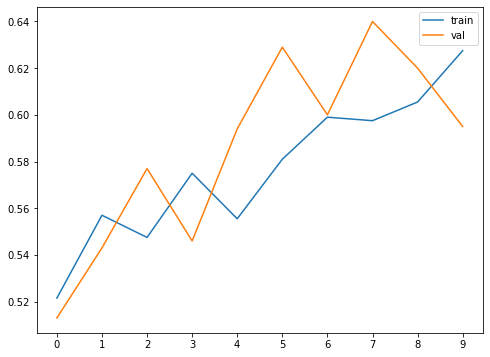

In [12]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(range(10))
plt.legend()
plt.show();

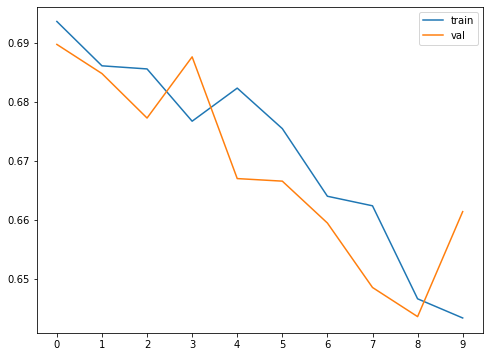

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xticks(range(10))
plt.legend()
plt.show();

### Question 3

What is the median of training accuracy for this model?

In [14]:
np.median(history.history['accuracy']).round(3)

0.578

### Question 4

What is the standard deviation of training loss for this model?

In [15]:
np.std(history.history['loss']).round(3)

0.016

### Data Augmentation

For the next two questions, we'll generate more data using data augmentations. 

Add the following augmentations to your training data generator:

* `rotation_range=40,`
* `width_shift_range=0.2,`
* `height_shift_range=0.2,`
* `shear_range=0.2,`
* `zoom_range=0.2,`
* `horizontal_flip=True,`
* `fill_mode='nearest'`

### Question 5 

Let's train our model for 10 more epochs using the same code as previously.
Make sure you don't re-create the model - we want to continue training the model
we already started training.

What is the mean of validation loss for the model trained with augmentations?

In [17]:
train_generator_aug = ImageDataGenerator(rescale=1./255,
                                         rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         fill_mode='nearest')

train_ds_aug = train_generator_aug.flow_from_directory('train', 
                                                       target_size=(150, 150), 
                                                       batch_size=20, 
                                                       class_mode='binary',
                                                       shuffle=True)

Found 20000 images belonging to 2 classes.


In [18]:
val_generator_aug = ImageDataGenerator(rescale=1./255,
                                         rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         fill_mode='nearest')

val_ds_aug = val_generator_aug.flow_from_directory('validation', 
                                                   target_size=(150, 150), 
                                                   batch_size=20, 
                                                   class_mode='binary', 
                                                   shuffle=True)

Found 5000 images belonging to 2 classes.


In [19]:
history_aug = model.fit(train_ds_aug, 
                        steps_per_epoch=100, 
                        epochs=10, 
                        validation_data=val_ds_aug, 
                        validation_steps=50)

Epoch 1/10
100/100 [==============================] - 32s 322ms/step - loss: 0.6649 - accuracy: 0.5875 - val_loss: 0.6649 - val_accuracy: 0.5860
Epoch 2/10
100/100 [==============================] - 32s 315ms/step - loss: 0.6634 - accuracy: 0.5910 - val_loss: 0.6708 - val_accuracy: 0.5560
Epoch 3/10
100/100 [==============================] - 32s 317ms/step - loss: 0.6704 - accuracy: 0.5730 - val_loss: 0.6650 - val_accuracy: 0.5830
Epoch 4/10
100/100 [==============================] - 31s 314ms/step - loss: 0.6612 - accuracy: 0.6010 - val_loss: 0.6572 - val_accuracy: 0.5830
Epoch 5/10
100/100 [==============================] - 32s 317ms/step - loss: 0.6548 - accuracy: 0.5985 - val_loss: 0.6460 - val_accuracy: 0.6160
Epoch 6/10
100/100 [==============================] - 31s 313ms/step - loss: 0.6582 - accuracy: 0.6095 - val_loss: 0.6373 - val_accuracy: 0.6370
Epoch 7/10
100/100 [==============================] - 32s 315ms/step - loss: 0.6579 - accuracy: 0.5965 - val_loss: 0.6664 - val_ac

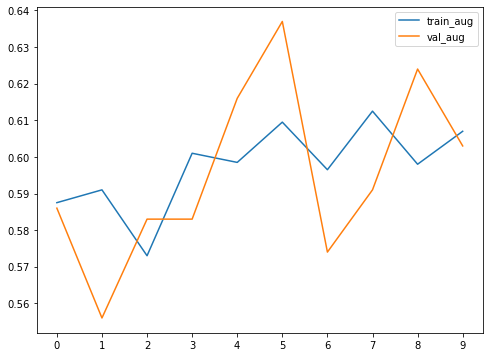

In [20]:
plt.plot(history_aug.history['accuracy'], label='train_aug')
plt.plot(history_aug.history['val_accuracy'], label='val_aug')
plt.xticks(range(10))
plt.legend()
plt.show();

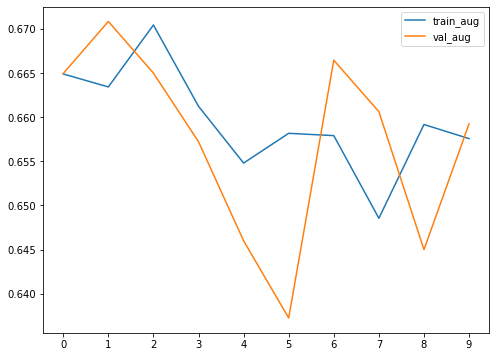

In [21]:
plt.plot(history_aug.history['loss'], label='train_aug')
plt.plot(history_aug.history['val_loss'], label='val_aug')
plt.xticks(range(10))
plt.legend()
plt.show();

In [22]:
np.mean(history_aug.history['val_loss']).round(3)

0.657

**Answer: 0.67**

### Question 6

What's the average of validation accuracy for the last 5 epochs (from 6 to 10)
for the model trained with augmentations?

In [26]:
np.mean(history_aug.history['val_accuracy'][-5:]).round(3)

0.606

**Answer: 0.65**